In [4]:
#Import Packages

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.tokenize import word_tokenize
import string
import seaborn as sns
from nltk.stem.porter import * 
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
from nltk.corpus import stopwords
from textblob import TextBlob
import numpy as np

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize # import word_tokenize

from nltk.corpus import stopwords #import stop words
import re # import regular expression
from nltk.tokenize import word_tokenize # import word_tokenize
from sklearn.utils import shuffle # to shuffle the data
import random # import random
import sklearn # import sklearn
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS

In [9]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
# Loading the Dataset

dataset = pd.read_csv('#BBIKenya.csv', encoding = "ISO-8859-1")
dataset.head(3)

,0,1,2,3,4,5,6,7
0,2019-10-25 14:53:25,"RT @JerotichSeii: Thank you, @Hakeenah. This i...",en,"Nairobi, Kenya",False,Twitter for Android,108,0
1,2019-10-25 14:51:40,RT @rariedabull: The magnificent building unde...,en,Ciudad de Mexico,False,Twitter for Android,64,0
2,2019-10-25 14:49:18,"RT @JerotichSeii: Thank you, @Hakeenah. This i...",en,127.0.0.1,False,Twitter for Android,108,0


# Data Preprocessing, Mnaipulation and Feature Engineering

In [11]:
dataset = dataset.rename(columns={'0': 'Datetime Created', '1': 'Tweet','2':'Language','3':'Location','4':'UserAccount Verified','5':'Tweet Source','6':'Retweet_count','7':'Favourite_count'})

In [12]:
dataset.head(3)

,Datetime Created,Tweet,Language,Location,UserAccount Verified,Tweet Source,Retweet_count,Favourite_count
0,2019-10-25 14:53:25,"RT @JerotichSeii: Thank you, @Hakeenah. This i...",en,"Nairobi, Kenya",False,Twitter for Android,108,0
1,2019-10-25 14:51:40,RT @rariedabull: The magnificent building unde...,en,Ciudad de Mexico,False,Twitter for Android,64,0
2,2019-10-25 14:49:18,"RT @JerotichSeii: Thank you, @Hakeenah. This i...",en,127.0.0.1,False,Twitter for Android,108,0


In [13]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
from nltk.sentiment import vader
from nltk.sentiment.util import *

from nltk import tokenize

sid = vader.SentimentIntensityAnalyzer()

In [16]:
dataset['sentiment_compound_polarity']=dataset.Tweet.apply(lambda x:sid.polarity_scores(x)['compound'])

dataset['sentiment_negative']=dataset.Tweet.apply(lambda x:sid.polarity_scores(x)['neg'])
dataset['sentiment_pos']=dataset.Tweet.apply(lambda x:sid.polarity_scores(x)['pos'])
dataset['Sentiment']=''
dataset.loc[dataset.sentiment_compound_polarity>=0,'Sentiment']=1

dataset.loc[dataset.sentiment_compound_polarity<0,'Sentiment']=0
dataset.head(2)

,Datetime Created,Tweet,Language,Location,UserAccount Verified,Tweet Source,Retweet_count,Favourite_count,sentiment_compound_polarity,sentiment_negative,sentiment_pos,Sentiment
0,2019-10-25 14:53:25,"RT @JerotichSeii: Thank you, @Hakeenah. This i...",en,"Nairobi, Kenya",False,Twitter for Android,108,0,0.3612,0.0,0.135,1
1,2019-10-25 14:51:40,RT @rariedabull: The magnificent building unde...,en,Ciudad de Mexico,False,Twitter for Android,64,0,0.6369,0.0,0.206,1


In [17]:
from datetime import date

In [18]:
dataset['Datetime Created'] = pd.to_datetime(dataset['Datetime Created'])

In [19]:
dataset['Year'] = dataset['Datetime Created'].dt.year
dataset['Week of the Year'] = dataset['Datetime Created'].dt.weekofyear
dataset['Day of the Year'] = dataset['Datetime Created'].dt.dayofyear
dataset['Month_name'] = dataset['Datetime Created'].dt.month_name()
dataset['Day of the Week'] = dataset['Datetime Created'].dt.weekday
dataset['Name of the Day'] = dataset['Datetime Created'].dt.day_name()
dataset['Hour'] = dataset['Datetime Created'].dt.hour
dataset['Minute'] = dataset['Datetime Created'].dt.minute

In [20]:
dataset["Tweet_length"] = dataset["Tweet"].apply(lambda x: len(x))

Text(0.5, 1.0, 'The Number of Tweets by Hour')

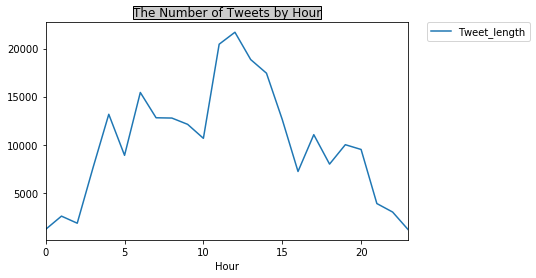

In [22]:
tweets_hour = dataset.groupby(['Hour'])['Tweet_length'].sum()
import seaborn as sns
tweets_hour.transpose().plot(kind='line',figsize=(6.5, 4))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('The Number of Tweets by Hour', bbox={'facecolor':'0.8', 'pad':0})

## Data Preprocessing the Tweets

In [23]:
# Preprocessing del RT @blablabla:
dataset['tweetos'] = '' 

# add tweetos first part
for i in range(len(dataset['Tweet'])):
    try:
        dataset['tweetos'][i] = dataset['Tweet'].str.split(' ')[i][0]
    except AttributeError:    
        dataset['tweetos'][i] = 'other'

# Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(dataset['Tweet'])):
    if dataset['tweetos'].str.contains('@')[i]  == False:
        dataset['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(dataset['Tweet'])):
    dataset['Tweet'][i] = " ".join([word for word in dataset['Tweet'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])   
        
display(dataset.Tweet.head(10))

0    RT Thank you, This is the concerted effort of ...
1    RT The magnificent building under intense fire...
2    RT Thank you, This is the concerted effort of ...
3                         RT Seen this? #SwitchOffKPLC
4    RT surely can a corrupt deliver justice for Ke...
5    RT Thank you, This is the concerted effort of ...
6    RT Why does have it in for our mothers &amp; g...
7    RT Thank you, This is the concerted effort of ...
8                  RT 1. is still stuck on the Sh35â¦
9    RT Thank you, This is the concerted effort of ...
Name: Tweet, dtype: object

In [25]:
import numpy as np
import pandas as pd
from subprocess import check_output
from bs4 import BeautifulSoup
import re
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from nltk.corpus import stopwords

In [26]:
def clean(x):
    #Remove Html  
    x=BeautifulSoup(x).get_text()
    
    #Remove Non-Letters
    x=re.sub('[^a-zA-Z]',' ',x)
    
    #Convert to lower_case and split
    x=x.lower().split()
    
    #Remove stopwords
    stop=set(stopwords.words('english'))
    words=[w for w in x if not w in stop]
    
    #join the words back into one string
    return(' '.join(words))

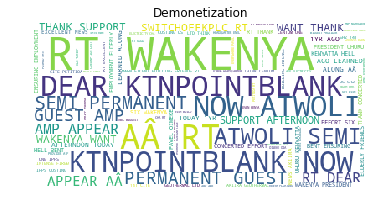

In [29]:
def wordcloud_by_province(dataset):
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("00A0")
    stopwords.add("00BD")
    stopwords.add("00B8")
    stopwords.add("ed")
    stopwords.add("demonetization")
    stopwords.add("Demonetization co")
    #Narendra Modi is the Prime minister of India
    stopwords.add("lakh")
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in dataset['Tweet'].str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Demonetization")

wordcloud_by_province(dataset)

# Model Building Process

In [30]:
eng_features = ['Tweet_length', 'Retweet_count', 'Day of the Week', 
                'Hour', 'Year']

In [31]:
train_target = dataset['Sentiment'].values

np.unique(train_target)

array([0, 1])

In [32]:
train_target.mean()

0.8225352112676056

In [35]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

import lightgbm as lgb

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import nltk
from nltk.corpus import stopwords
import string

from scipy.sparse import hstack

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred = 0
oof_pred = np.zeros([dataset.shape[0],])

x_test = dataset[eng_features].values
for i, (train_index, val_index) in tqdm(enumerate(kf.split(dataset))):
    x_train, x_val = dataset.loc[train_index][eng_features].values, dataset.loc[val_index][eng_features].values
    y_train, y_val = train_target[train_index], train_target[val_index]
    classifier = LogisticRegression(C= 0.1)
    classifier.fit(x_train, y_train)
    val_preds = classifier.predict_proba(x_val)[:,1]
    preds = classifier.predict_proba(x_test)[:,1]
    test_pred += 0.2*preds
    oof_pred[val_index] = val_preds

5it [00:00, 26.80it/s]


In [37]:
pred_train = (oof_pred > 0.5).astype(np.int)
f1_score(train_target, pred_train)

0.9026275115919629

In [38]:
f1_score(train_target, pred_train)

0.9026275115919629

In [39]:
pred_train = (oof_pred > 0.12).astype(np.int)
f1_score(train_target, pred_train)

0.9026275115919629

#### For our second model we'll use TF-IDF with a logistic regression. The next couple of secontions are based on my LR with n-grams notebook. Firtst, let's embed all the text vectors:

In [74]:
train_text = dataset['Tweet']


word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=5000)
word_vectorizer.fit(train_text)
train_word_features = word_vectorizer.transform(train_text)

### Now let's see how well a logistic regression trained on these features does:

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_tf = 0
oof_pred_tf = np.zeros([dataset.shape[0],])

for i, (train_index, val_index) in tqdm(enumerate(kf.split(dataset))):
    x_train, x_val = train_word_features[train_index,:], train_word_features[val_index,:]
    y_train, y_val = train_target[train_index], train_target[val_index]
    classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
    classifier.fit(x_train, y_train)
    val_preds = classifier.predict_proba(x_val)[:,1]
    preds = classifier.predict_proba(train_word_features)[:,1]
    test_pred_tf += 0.2*preds
    oof_pred_tf[val_index] = val_preds

5it [00:00, 90.74it/s]


In [42]:
pred_train = (oof_pred_tf > 0.8).astype(np.int)
f1_score(train_target, pred_train)

0.7858627858627859

In [43]:
pred_train = (0.8*oof_pred_tf+0.2*oof_pred > 0.68).astype(np.int)
f1_score(train_target, pred_train)

0.9664666431344864

### The following Logistic Regression is based  Count Vectorizer notebook:

In [44]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()

In [45]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_cv = 0
oof_pred_cv = np.zeros([dataset.shape[0],])


for i, (train_index, val_index) in tqdm(enumerate(kf.split(dataset))):
    x_train, x_val = dataset.loc[train_index]['Tweet'].values, dataset.loc[val_index]['Tweet'].values
    y_train, y_val = train_target[train_index], train_target[val_index]
    x_test = dataset['Tweet'].values
    
    bow = CountVectorizer()
    x_train = bow.fit_transform(x_train)
    x_val = bow.transform(x_val)
    x_test = bow.transform(x_test)

    classifier = LogisticRegression(penalty = "l1", C = 1.25, class_weight = "balanced")
    
    classifier.fit(x_train, y_train)
    val_preds = classifier.predict_proba(x_val)[:,1]
    preds = classifier.predict_proba(x_test)[:,1]
    test_pred_cv += 0.2*preds
    oof_pred_cv[val_index] = val_preds

5it [00:00, 12.54it/s]


### The following classifiers are inspired by  Naive Bayes notebook:

In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_cv_2 = 0
oof_pred_cv_2 = np.zeros([dataset.shape[0],])
test_pred_cv_3 = 0
oof_pred_cv_3 = np.zeros([dataset.shape[0],])


for i, (train_index, val_index) in tqdm(enumerate(kf.split(dataset))):
    x_train, x_val = dataset.loc[train_index]['Tweet'].values, dataset.loc[val_index]['Tweet'].values
    y_train, y_val = train_target[train_index], train_target[val_index]
    x_test = dataset['Tweet'].values
    
    bow = CountVectorizer()
    x_train = bow.fit_transform(x_train)
    x_val = bow.transform(x_val)
    x_test = bow.transform(x_test)
    
    classifier2 = MultinomialNB()
    classifier3 = BernoulliNB()
    
    classifier2.fit(x_train, y_train)
    val_preds = classifier2.predict_proba(x_val)[:,1]
    preds = classifier2.predict_proba(x_test)[:,1]
    test_pred_cv_2 += 0.2*preds
    oof_pred_cv_2[val_index] = val_preds
    
    classifier3.fit(x_train, y_train)
    val_preds = classifier3.predict_proba(x_val)[:,1]
    preds = classifier3.predict_proba(x_test)[:,1]
    test_pred_cv_3 += 0.2*preds
    oof_pred_cv_3[val_index] = val_preds

5it [00:00, 13.66it/s]


In [47]:
pred_train = (oof_pred_cv > 0.75).astype(np.int)
f1_score(train_target, pred_train)

0.9821551132463968

In [48]:
pred_train = (oof_pred_cv_2 > 0.7).astype(np.int)
f1_score(train_target, pred_train)

0.9703315881326352

In [49]:
pred_train = (oof_pred_cv_3 > 0.7).astype(np.int)
f1_score(train_target, pred_train)

0.9786206896551723

In [50]:
pred_train = (0.7*oof_pred_cv+0.2*oof_pred_cv_2+0.1*oof_pred_cv_3 > 0.7).astype(np.int)
f1_score(train_target, pred_train)

0.9803516028955533

In [80]:
import lightgbm as lgb

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

params = {'learning_rate': 0.05,
          'application': 'regression',
          'max_depth': 9,
          'num_leaves': 100,
          'verbosity': -1,
          'metric': 'rmse',
          'data_random_seed': 3,
          'bagging_fraction': 0.8,
          'feature_fraction': 0.4,
          'nthread': 16,
          'lambda_l1': 1,
          'lambda_l2': 1,
          'num_rounds': 2700,
          'verbose_eval': 100}


kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_lgb = 0
oof_pred_lgb = np.zeros([dataset.shape[0],])

for i, (train_index, val_index) in tqdm(enumerate(kf.split(dataset))):
    x_train, x_val = train_word_features[train_index,:], train_word_features[val_index,:]
    y_train, y_val = train_target[train_index], train_target[val_index]
    
    d_train = lgb.Dataset(x_train, label=y_train)
    d_valid = lgb.Dataset(x_val, label=y_val)

    num_rounds = 2500
    model = lgb.train(params,
                  train_set=d_train,
                  num_boost_round=num_rounds,
                  valid_sets=[d_train, d_valid],
                  valid_names=['train', 'val'],
                  verbose_eval=0)
    
    val_preds = model.predict(x_val)
    preds = classifier.predict(train_word_features)
    test_pred_lgb += 0.2*preds
    oof_pred_lgb[val_index] = val_preds

0it [00:05, ?it/s]


ValueError: X has 1029 features per sample; expecting 1080

In [78]:
pred_train = (oof_pred_lgb > 0.3).astype(np.int)
f1_score(train_target, pred_train)

0.0

In [79]:
pred_train = (0.65*oof_pred_lgb+0.35*oof_pred_tf+0.1*oof_pred > 0.5).astype(np.int)
f1_score(train_target, pred_train)

0.0

## The Stacked Model

In [63]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_stack = 0
oof_pred_stack = np.zeros([dataset.shape[0],])

for i, (train_index, val_index) in tqdm(enumerate(kf.split(dataset))):
    y_train, y_val = train_target[train_index], train_target[val_index]
    classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
    classifier.fit(x_train, y_train)
    val_preds = classifier.predict_proba(x_val)[:,1]
    test_pred_stack += 0.2*preds
    oof_pred_stack[val_index] = val_preds

5it [00:00, 18.44it/s]


In [64]:
score = 0
thresh = .5
for i in np.arange(0.1, 0.951, 0.01):
    temp_score = f1_score(train_target, (oof_pred_stack > i))
    if(temp_score > score):
        score = temp_score
        thresh = i

print("CV: {}, Threshold: {}".format(score, thresh))

CV: 0.9118773946360154, Threshold: 0.15999999999999998


### Saving a Submission CSV File

In [66]:
pred_test = ( test_pred_stack> thresh).astype(np.int)
submission = pd.DataFrame.from_dict({'Tweet': dataset['Tweet']})
submission['prediction'] = pred_test
submission.to_csv('submission.csv', index=False)